In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
from sklearn.tree import export_graphviz
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import numpy as np

# 06. 决策树
和支持向量机一样， 决策树是一种多功能机器学习算法， 即可以执行分类任务也可以执行回归任务，甚至包括多输出(multioutput)任务。决策树是一种功能很强大的算法，可以对很复杂的数据集进行拟合。例如，在第二章中我们对加利福尼亚住房数据集使用决策树回归模型进行训练，就很好的拟合了数据集(实际上是过拟合)。

决策树也是随机森林的基本组成部分(见第7章)，而随机森林是当今最强大的机器学习算法之一。

在本章中，我们将首先讨论如何使用决策树进行训练，可视化和预测。然后我们会学习在Scikit-learn上面使用`CART算法`，并且探讨如何调整决策树让它可以用于执行回归任务。最后，我们当然也需要讨论一下决策树目前存在的一些局限性。

## 6.1 决策树的训练和可视化
为了理解决策树，我们需要先构建一个决策树并亲身体验它到底如何进行预测。接下来的代码就是在我们熟知的鸢尾花数据集上进行一个决策树分类器的训练。

In [2]:
iris = load_iris() 
X = iris.data[:, 2:] # petal length and width 
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2) 
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

你可以通过使用`export_graphviz()`方法，通过生成一个叫做`iris_tree.dot`的图形定义文件将一个训练好的决策树模型可视化。

```python
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, out_file=image_path("iris_tree.dot"), 
                feature_names=iris.feature_names[2:], 
                class_names=iris.target_names, 
                rounded=True, filled=True)
```

然后，我们可以利用`graphviz package`中的`dot`命令行，将`.dot`文件转换成PDF或PNG等多种数据格式。例如，使用命令行将.dot文件转换成.png文件的命令如下：

```bash
$ dot -Tpng iris_tree.dot -o iris_tree.png
```

我们的第一个决策树如`图6-1`。

<img src="images/06_01.png" style="width:500px;"/>

## 6.2 开始预测
现在让我们来看看在`图6-1`中的树是如何进行预测的。假设你找到了一朵鸢尾花并且想对它进行分类，你从根节点开始(深度为0，顶部)：该节点询问花朵的花瓣长度是否小于2.45厘米。如果是，您将向下移动到根的左侧子节点(深度为 1，左侧)。 在这种情况下，它是一片叶子节点(即它没有任何子节点)，所以它不会问任何问题：你可以方便地查看该节点的预测类别，决策树预测你的花是`Iris-Setosa`(class=setosa)。

现在假设你找到了另一朵花，但这次的花瓣长度是大于2.45厘米的。你必须向下移动到根的右侧子节点(深度为1，右侧)，而这个节点不是叶节点，所以它会问另一个问题：花瓣宽度是否小于1.75厘米？ 如果是，那么你的花很可能是一个`Iris-Versicolor`(深度为 2，左)。 如果不是，那很可能一个`Iris-Virginica`(深度为2，右)，真的是太简单了，对吧！

> 决策树的众多特性之一就是，它不需要太多的数据预处理，尤其是不需要进行特征的缩放或者归一化。

节点的`samples属性`统计出它应用于多少个训练样本实例。例如，我们有100个训练实例是花瓣长度大于2.45厘米的(深度为 1，右侧)，在这100个样本中又有54个花瓣宽度小于1.75cm(深度为2，左侧)。节点的`value属性`告诉你这个节点对于每一个类别的样例有多少个。例如：右下角的节点中包含0个Iris-Setosa，1个Iris-Versicolor和45个Iris-Virginica。最后，节点的`Gini属性`用于测量它的纯度：如果一个节点包含的所有训练样例全都是同一类别的，我们就说这个节点是纯的(`Gini=0`)。例如，深度为1的左侧节点只包含Iris-Setosa训练实例，它就是一个纯节点，Gini指数为0。

`公式6-1`显示了训练算法如何计算第i个节点的gini分数`G_i`。例如， 深度为2的左侧节点基尼指数为：
- $\displaystyle 1-\big(\frac{0}{54}\big)^2-\big(\frac{49}{54}\big)^2-\big(\frac{5}{54}\big)^2=0.68$

另外一个纯度指数也将在后文很快提到。

- $\displaystyle G_i = 1 - \sum_{k=1}^{n}P_{i,k}^2$

其中，$p_{i,k}$是第$i$个节点中训练实例为的$k$类实例的比例

> Scikit-Learn用的是`CART算法`，`CART算法`仅产生二叉树：每一个非叶节点总是只有两个子节点(只有是或否两个结果)。然而，像ID3这样的算法可以产生超过两个子节点的决策树模型

`图6-2`显示了决策树的决策边界。粗的垂直线代表根节点(深度为0)的决定边界：花瓣长度为2.45厘米。由于左侧区域是纯的(只有Iris-Setosa)，所以不能再进一步分裂。然而，右边的区域是不纯的，所以深度为1的右边节点在花瓣宽度为1.75厘米处分裂(用虚线表示)。又由于`max_depth`设置为2，决策树在那里停了下来。但是，如果将`max_depth`设置为3，那么会变成两个深度为2的节点，每个都将会添加另一个决策边界(用虚线表示)。

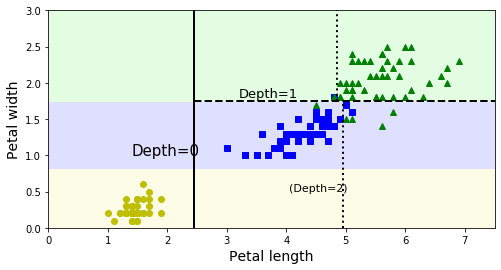

In [3]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
plt.show()

> **模型小知识：白盒与黑盒**
> 
> 正如我们看到的一样，决策树非常直观，他们的决定很容易被解释。这种模型通常被称为`白盒模型`。相反，随机森林或神经网络通常被认为是`黑盒模型`。他们能做出很好的预测，并且您可以轻松检查它们做出这些预测过程中计算的执行过程。然而，人们通常很难用简单的术语来解释为什么模型会做出这样的预测。例如，如果一个神经网络说一个特定的人出现在图片上，我们很难知道究竟是什么导致了这一个预测的出现：模型是否认出了那个人的眼睛？ 她的嘴？ 她的鼻子？她的鞋？或者是否坐在沙发上？ 相反，决策树提供良好的、简单的分类规则，甚至可以根据需要手动操作(例如鸢尾花分类)。

## 6.3 估计分类概率
决策树还可以估计某个实例属于特定类$k$的概率：首先遍历树来查找此实例的叶节点，然后它返回此节点中类$k$的训练实例的比例。

例如，假设你发现了一个花瓣长5厘米，宽1.5厘米的花朵。相应的叶节点是深度为2的左节点，因此决策树应该输出以下概率：Iris-Setosa为0%(0/54)，Iris-Versicolor为90.7%(49/54)，Iris-Virginica为9.3%(5/54)。当然，如果你要求它预测具体的类，它应该输出Iris-Versicolor(类别1)，因为它具有最高的概率。我们了测试一下：

In [4]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [5]:
tree_clf.predict([[5, 1.5]])

array([1])

完美！请注意，估计概率在任何地方都是相同的， 除了上图右下角的矩形部分，例如花瓣长6厘米和宽1.5厘米(尽管在这种情况下它看起来很可能是Iris-Virginica)。

## 6.4 CART训练算法
Scikit-Learn用`分裂回归树`(Classification And Regression Tree，简称 CART)算法训练决策树(也叫`增长树`)。这种算法思想真的非常简单：首先使用单个特征$k$和阈值$t_k$(例如，“花瓣长度≤2.45cm”)将训练集分成两个子集。它如何选择$k$和$t_k$呢？它寻找到能够产生最纯粹的子集一对$(k, t_k)$，然后通过子集大小加权计算。

算法会尝试最小化成本函数。方法如下：

- $\displaystyle J(k,t_k) = \frac{m_{\mathrm{left}}}{m}G_{\mathrm{left}}+\frac{m_{\mathrm{right}}}{m}G_{\mathrm{right}}$
    - $\displaystyle\begin{equation}where = \left\{\begin{array}{l}G_{\mathrm{left}/\mathrm{right}} & measures\ the\ impurity\ of\ the\ \mathrm{left}/\mathrm{right}\ subset, & \\ m_{\mathrm{left}/\mathrm{right}} & is\ the\ number\ of\ instances\ in\ the\ \mathrm{left}/\mathrm{right}\ subset\end{array}\right.\end{equation}$

当它成功的将训练集分成两部分之后，它将会继续使用相同的递归式逻辑继续的分割子集，然后是子集的子集。当达到预定的最大深度之后将会停止分裂(由`max_depth`超参数决定)，或者是它找不到可以继续降低不纯度的分裂方法的时候。几个其他超参数(之后介绍)控制了其他的停止生长条件(`min_samples_split`，`min_samples_leaf`，`min_weight_fraction_leaf`，`max_leaf_nodes`)。

> 正如您所看到的，CART算法是一种贪婪算法：它贪婪地搜索最高级别的最佳分割方式，然后在每个深度重复该过程。它不检查分割是否能够在几个级别中的全部分割可能中找到最佳方法。贪婪算法通常会产生一个相当好的解决方法，但它不保证这是全局中的最佳解决方案。
> 
> 不幸的是，找到最优树是一个NP完全问题：它需要$O(exp^m)$时间，即使对于相当小的训练集也会使问题变得棘手。 这就是为什么我们必须设置一个“合理的”(而不是最佳的)解决方案。

## 6.5 计算复杂度
在建立好决策树模型后，做出预测需要遍历决策树，从根节点一直到叶节点。决策树通常近似左右平衡，因此遍历决策树需要经历大致$O(log_2(m))$个节点。由于每个节点只需要检查一个特征的值，因此总体预测复杂度仅为$O(log_2(m))$，与特征的数量无关。所以即使在处理大型训练集时，预测速度也非常快。

> $log_2$是二进制对数，它等于$log_2(m) = \frac{log(m)}{log(2)}$。

然而，训练算法的时候(训练和预测不同)，算法模型需要在每个节点的所有样本上比较所有特征(如果设置了`max_features`会更少一些)。就有了$O(n×m log(m))$的训练复杂度。对于小型训练集(少于几千例)，Scikit-Learn 可以通过预先设置数据(`presort=True`)来加速训练，但是这对于较大训练集来说会显着减慢训练速度。

## 6.6 Gini不纯度或是信息熵
通常，算法使用Gini不纯度来进行检测，但是你也可以通过将`criterion超参数`设置为`entropy`来使用熵不纯度进行检测。这里熵的概念是源于热力学中分子混乱程度的概念，当分子井然有序的时候，熵值接近于0。在机器学习中，熵经常被用作不纯度的衡量方式，当一个集合内只包含一类实例时， 我们称为数据集的熵为0。熵的减少通常称为信息增益。

> 熵这个概念后来逐渐被扩展到了各个领域，其中包括香农的信息理论，这个理论被用于测算一段信息中的平均信息密度。当所有信息相同的时候熵被定义为零。

下面公式显示了第$i$个节点的熵的定义，例如，在`图6-1`中，深度为2的左节点的熵为$\displaystyle -\frac{49}{54}\log_2\big(\frac{49}{54}\big)-\frac{5}{54}\log_2\big(\frac{5}{54}\big)=0.31$。

- $\displaystyle H_i = - \sum_{{k=1,P_{i, k}\ne 0}}^n P_{i, k}log_2(p_{i,k})$

那么我们到底应该使用Gini指数还是熵呢？事实上大部分情况都没有多大的差别：他们会生成类似的决策树。基尼指数计算稍微快一点，所以这是一个很好的默认值。但是，也有的时候它们会产生不同的树，基尼指数会趋于在树的分支中将最多的类隔离出来，而熵指数趋向于产生略微平衡一些的决策树模型。 

## 6.7 正则化超参数
决策树几乎不对训练数据做任何假设(与此相反的是线性回归等模型，这类模型通常会假设数据是符合线性关系的)。如果不添加约束，树结构模型通常将根据训练数据调整自己，使自身能够很好的拟合数据，而这种情况下大多数会导致模型过拟合。这一类的模型通常会被称为`非参数模型`，这不是因为它没有任何参数(通常也有很多)，而是因为在训练之前没有确定参数的具体数量，所以模型结构可以根据数据的特性自由生长。与此相反的是，像线性回归这样的参数模型有事先设定好的参数数量，所以自由度是受限的，这就减少了过拟合的风险(但是增加了欠拟合的风险)。

为了防止模型过拟合训练集，你必须限制决策树在训练时的自由度。我们已经知道这种限制叫做`正则化`。每种算法的正则化参数不同，对于决策树，通常可以选择约束树的最大深度。在Scikit-Learn中，这个深度由超参数`max_depth`控制(默认值为None，即不作任何限制)。降低超参数`max_depth`的值会对决策树产生更强的约束，也就减少了过拟合的风险。

`DecisionTreeClassifier类`还有一些其他的参数用于限制树模型的形状:
+ min_samples_split：节点在被分裂之前必须具有的最小样本数
+ min_samples_leaf：叶节点必须具有的最小样本数
+ min_weight_fraction_leaf：和min_samples_leaf相同，但表示为加权总数的一小部分实例
+ max_leaf_nodes：叶节点的最大数量
+ max_features：在每个节点被评估是否分裂的时候，具有的最大特征数量

增加`min_*`超参数或者减少`max_*`超参数会使模型正则化。

> 一些其他算法的工作原理是在没有任何约束条件下训练决策树模型，让模型自由生长，然后再对不需要的节点进行剪枝。当一个节点的全部子节点都是叶节点时，如果它对纯度的提升不具有统计学意义，我们就认为这个分支是不必要的。标准的假设检验，例如`卡方检测`，通常会被用于评估一个概率值 -- 即改进是否纯粹是偶然性的结果(也叫原假设)。如果`p`值比给定的阈值更高(通常设定为5%，也就是95%置信度，通过超参数设置)，那么节点就被认为是非必要的，它的子节点会被删除。

这种剪枝方式将会一直进行，直到所有的非必要节点都被删光。

`图6-3`显示了对`moons数据集`(在第5章介绍过)进行训练生成的两个决策树模型，左侧的图形对应的决策树使用默认超参数生成(没有限制生长条件)，右边的决策树模型设置为`min_samples_leaf=4`。很明显，左边的模型过拟合了，而右边的模型泛用性更好。

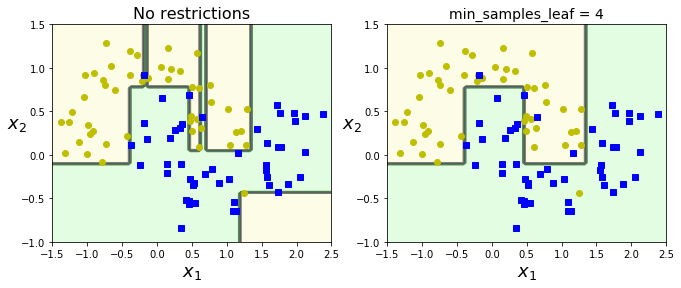

In [6]:
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)

plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.show()

## 6.8 回归
决策树也能够执行回归任务，让我们使用Scikit-Learn的`DecisionTreeRegressor`类构建一个回归树，让我们用`max_depth=2`在具有噪声的二次项数据集上进行训练。

In [7]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

tree_reg = DecisionTreeRegressor(max_depth=2) 
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

结果如`图6-4`所示：

<img src="images/06_04.png" style="width:500px;"/>

这棵树看起来非常类似于你之前建立的分类树，它的主要区别在于，它不是预测每个节点中的样本所属的分类，而是预测一个具体的数值。例如，假设您想对$x_1 = 0.6$的新实例进行预测。从根开始遍历树，最终到达预测值等于`0.1106`的叶节点。该预测仅仅是与该叶节点相关的110个训练实例的平均目标值。而这个预测结果在对应的110个实例上的`均方误差`(MSE)等于`0.0151`。

在`图6-5`的左侧显示的是模型的预测结果，如果你将`max_depth`设置为`3`，模型就会如`图6-5`右侧显示的那样。注意每个区域的预测值总是该区域中实例的平均目标值。算法以一种使大多数训练实例尽可能接近该预测值的方式分割每个区域。

> 译者注：图里面的红线就是训练实例的平均目标值，对应上图中的value

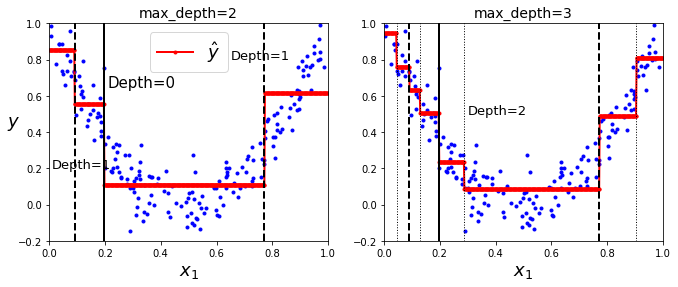

In [8]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)

for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)

for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)

plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

CART算法的工作方式与之前处理分类模型基本一样，不同之处在于，现在不再以最小化不纯度的方式分割训练集，而是试图以最小化`MSE`的方式分割训练集。

`公式6-4`显示了成本函数，该算法试图最小化这个成本函数。

- $\displaystyle J(k,t_k) = \frac{m_{\mathrm{left}}}{m}\mathrm{MES}_{\mathrm{left}}+\frac{m_{\mathrm{right}}}{m}\mathrm{MSE}_{\mathrm{right}}$

    - $\displaystyle\begin{equation}where = \left\{\begin{array}{l}  \mathrm{MSE}_{\mathrm{node}} = \sum_{i\in \mathrm{node}}\big(\hat{y}_{\mathrm{node}}-y^{(i)}\big)^2 &\\ \hat{y}_{\mathrm{node}}=\frac{1}{\mathrm{m}_{\mathrm{node}}}\sum_{i\in \mathrm{node}} y^{(i)} \end{array}\right.\end{equation}$

和处理分类任务时一样，决策树在处理回归问题的时候也容易过拟合。如果不添加任何正则化(默认的超参数)，你就会得到`图6-6`左侧的预测结果，显然，过度拟合的程度非常严重。而当我们设置了`min_samples_leaf = 10`，相对就会产生一个更加合适的模型了，就如`图6-6`右侧所示的那样。

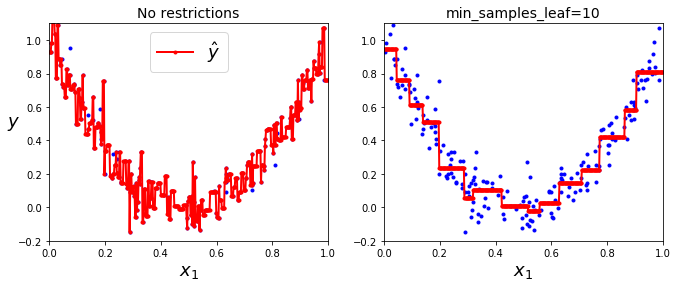

In [9]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

## 6.9 不稳定性
我希望你现在了解了决策树到底有哪些特点：它很容易理解和解释，易于使用且功能丰富而强大。然而，它也有一些限制，首先，你可能已经注意到了，决策树很喜欢设定正交化的决策边界(所有边界都是和某一个轴相垂直的)，这使得它对训练数据集的旋转很敏感，例如`图6-7`显示了一个简单的线性可分数据集。在左图中，决策树可以轻易的将数据分隔开，但是在右图中，当我们把数据旋转了`45°`之后，决策树的边界看起来变的格外复杂。尽管两个决策树都完美的拟合了训练数据，右边模型的泛化能力很可能非常差。解决这个难题的一种方式是使用PCA主成分分析(第八章)，这样通常能使训练结果变得更好一些。

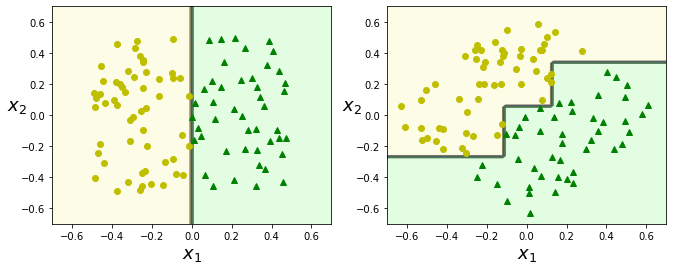

In [10]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.show()

更加通俗的讲，决策树的主要问题是它对训练数据的微小变化非常敏感。举例来说，我们仅仅从鸢尾花训练数据中将最宽的`Iris-Versicolor`拿掉(花瓣长4.8厘米，宽1.8厘米)，然后重新训练决策树模型，你可能就会得到`图6-8`中的模型。正如我们看到的那样，决策树有了非常大的变化(原来的如`图6-2`)。事实上，由于Scikit-Learn的训练算法是非常随机的，即使是相同的训练数据你也可能得到差别很大的模型(除非你设置了随机数种子)。

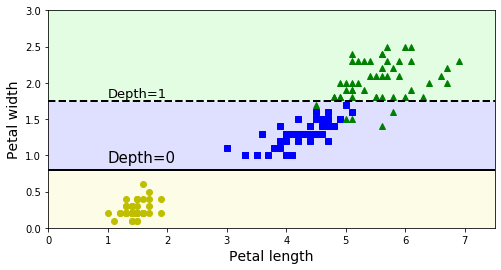

In [11]:
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)]

not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

plt.show()